[ref](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
ngpu=0

In [5]:
df = fetch_openml(data_id=41214, as_frame=True)["data"].dropna()

df[df.select_dtypes(['float64']).columns] = (df[df.select_dtypes(['float64']).columns] - df[df.select_dtypes(['float64']).columns].mean()) / df[df.select_dtypes(['float64']).columns].std()

df = df.sample(n=10**5, random_state=43)


for feat in df.select_dtypes(['category']).columns:
    df[feat] = df[feat].values.codes

for feat in df.columns:
    num_new_feats = len(df[feat].unique())
    if df[feat].dtype != "float64":
        new_feats = OneHotEncoder(sparse=False).fit_transform(df[feat].values.reshape(-1,1))
        for idx in range(num_new_feats):
            df[f"{feat}_{idx}"] = new_feats[:,idx]
            df[f"{feat}_{idx}"] = df[f"{feat}_{idx}"].astype("float")
        del df[feat]


x = df.drop(columns="ClaimNb").values
y = df["ClaimNb"].values
print(x.shape, y.shape)

(100000, 48) (100000,)


In [6]:
n_samples = x.shape[0] # 10**5
n_feats = x.shape[1] # 10

In [7]:
# x = np.random.randn(n_samples, n_feats)
# w = np.random.randn(n_feats)
# y = x.dot(w) + 2*np.random.randn(n_samples)

In [8]:
y.min(), y.max()

(-0.22175311776058076, 66.41233768372616)

### Simple Linear Regression check

In [9]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x, y)
reg.coef_

array([-1.49121498e-01,  7.32334338e-02,  2.09144994e-03, -2.89256704e-02,
        4.69718831e-02,  8.97990807e-02,  6.82697376e-03, -3.16208758e+09,
       -3.16208758e+09, -3.16208758e+09, -3.16208758e+09, -3.16208758e+09,
       -3.16208758e+09, -6.48092280e+09, -6.48092280e+09, -6.48092280e+09,
       -6.48092280e+09, -6.48092280e+09, -6.48092280e+09, -6.48092280e+09,
       -6.48092280e+09, -6.48092280e+09, -6.48092280e+09, -6.48092280e+09,
       -4.88841816e+10, -4.88841816e+10, -4.93086815e+09, -4.93086815e+09,
       -4.93086815e+09, -4.93086815e+09, -4.93086815e+09, -4.93086815e+09,
       -4.93086815e+09, -4.93086815e+09, -4.93086815e+09, -4.93086815e+09,
       -4.93086815e+09, -4.93086815e+09, -4.93086815e+09, -4.93086815e+09,
       -4.93086815e+09, -4.93086815e+09, -4.93086815e+09, -4.93086815e+09,
       -4.93086815e+09, -4.93086815e+09, -4.93086815e+09, -4.93086815e+09])

In [10]:
reg.score(x, y), (1-reg.score(x, y))*y.var()

(0.029027146229226752, 1.00917267564145)

# Regress GAN

### Define ANN Architecture

In [11]:
# Batch size during training
batch_size = 128

# Size of z latent vector (i.e. size of generator input)
nz = 5

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# width of the network
network_width = 128

In [12]:
# create train and test indices
train, test = train_test_split(list(range(x.shape[0])), test_size=.2)
train, val = train_test_split(train, test_size=.25)

In [13]:
# https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
class PrepareData(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X.float32()
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y).float()
        else:
            self.y = y.float32()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = PrepareData(x, y=y, scale_X=False)

train_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(train))
val_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(val))
test_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))

In [14]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear( n_feats+nz, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, 1, bias=True)

        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the generator
netG = Generator(ngpu).to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=53, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [16]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(n_feats+1, network_width, bias=True), # i/p is covariates and o/p
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( network_width, network_width, bias=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( network_width, 1, bias=True),
            nn.Sigmoid(),

        )

    def forward(self, input):
        return self.main(input)

In [17]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=49, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [18]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [19]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

G_losses_val = []
D_losses_val = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_set, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        fake_cpu = torch.hstack((data[0],fake.detach())).to(device)
        output = netD(fake_cpu.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        fake_cpu = torch.hstack((data[0],fake)).to(device)
        output = netD(fake_cpu).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_set),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                
        # Output validation stats
        if i % 100 == 0:
            with torch.no_grad():
                errG_vals = []
                errD_vals = []
                for i, data in enumerate(val_set, 0):
                    b_size = data[0].size(0)
                    noise = torch.randn(b_size, nz, device=device)
                    # Generate fake image batch with G
                    gen_ip = torch.hstack((data[0],noise)).to(device)
                    gen_op = netG(gen_ip)
                    
                    fake_cpu = torch.hstack((data[0],gen_op)).to(device)
                    fake_output = netD(fake_cpu).view(-1)

                    label.fill_(real_label) # fake labels are real for generator cost
                    errG_val = criterion(output, label)  
                    
                    label.fill_(fake_label)
                    errD_fake_val = criterion(output, label)
                    
                    real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
                    real_output = netD(real_cpu).view(-1)
                    
                    label.fill_(real_label)
                    errD_real_val = criterion(output, label)
                    
                    errG_vals.append(errG_val.item())
                    errD_vals.append((errD_fake_val+errD_real_val).item())
            G_losses_val.append(sum(errG_vals)/len(errG_vals))
            D_losses_val.append(sum(errD_vals)/len(errD_vals))
        
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_set)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.3873	Loss_G: 0.6703	D(x): 0.5132	D(G(z)): 0.5132 / 0.5116
[1/5][0/469]	Loss_D: 1.3078	Loss_G: 0.7766	D(x): 0.5122	D(G(z)): 0.4601 / 0.4601
[2/5][0/469]	Loss_D: 1.3518	Loss_G: 0.7175	D(x): 0.5127	D(G(z)): 0.4880 / 0.4882
[3/5][0/469]	Loss_D: 1.3530	Loss_G: 0.7174	D(x): 0.5120	D(G(z)): 0.4877 / 0.4882
[4/5][0/469]	Loss_D: 1.3483	Loss_G: 0.7163	D(x): 0.5167	D(G(z)): 0.4888 / 0.4887


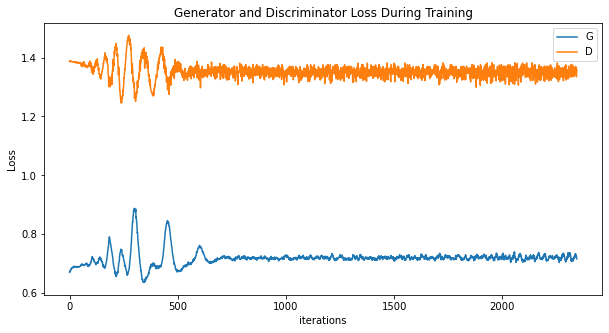

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

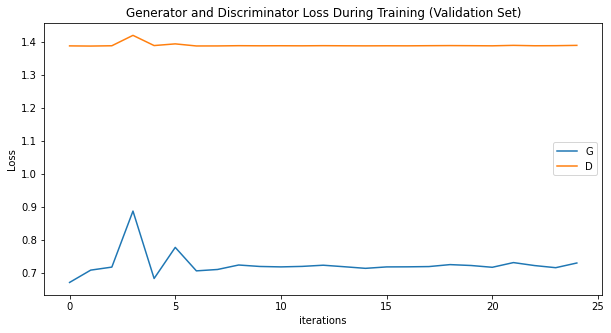

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training (Validation Set)")
plt.plot(G_losses_val,label="G")
plt.plot(D_losses_val,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train Predictions

In [22]:
train_ops = []
with torch.no_grad():
    for i, data in enumerate(train_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        train_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [23]:
train_reals = np.concatenate(list(x[0] for x in train_ops))
train_preds = np.concatenate(list(x[1] for x in train_ops))

In [24]:
df_results_train = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(train_reals,1),train_preds
    ))
    ,columns = ["true","pred"]
)

df_results_train.describe()

,true,pred
count,60000.000000,60000.000000
mean,-0.001583,-0.176489
std,1.002740,0.028384
min,-0.221753,-0.279848
25%,-0.221753,-0.194853
50%,-0.221753,-0.180073
75%,-0.221753,-0.162522
max,45.589184,0.185729


In [25]:
df_results_train["pred_segment"] = pd.qcut(df_results_train["pred"],10)
df_results_train.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.281, -0.208]",-0.057944,-0.218035
"(-0.208, -0.198]",-0.051697,-0.202581
"(-0.198, -0.192]",-0.047533,-0.194906
"(-0.192, -0.186]",-0.043368,-0.188614
"(-0.186, -0.18]",-0.036427,-0.182928
"(-0.18, -0.174]",-0.056556,-0.177018
"(-0.174, -0.167]",-0.010051,-0.170442
"(-0.167, -0.157]",0.016325,-0.162302
"(-0.157, -0.141]",0.072547,-0.150173


In [26]:
mean_squared_error(df_results_train["true"], df_results_train["pred"]), df_results_train["true"].var()

(1.0327511, 1.0054879)

In [27]:
mean_absolute_error(df_results_train["true"], df_results_train["pred"]), (
    df_results_train["true"]-df_results_train["true"].mean()
).abs().mean()

(0.26044333, 0.41838926)

## Test Predictions

In [28]:
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        test_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [29]:
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))

In [30]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,-0.000403,-0.176310
std,1.091805,0.028462
min,-0.221753,-0.270451
25%,-0.221753,-0.194780
50%,-0.221753,-0.179825
75%,-0.221753,-0.162376
max,66.412338,0.188541


In [31]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.271, -0.207]",-0.019769,-0.217850
"(-0.207, -0.198]",-0.051003,-0.202477
"(-0.198, -0.191]",-0.063497,-0.194790
"(-0.191, -0.186]",-0.013522,-0.188466
"(-0.186, -0.18]",-0.032262,-0.182706
"(-0.18, -0.174]",-0.046839,-0.176870
"(-0.174, -0.167]",-0.071826,-0.170358
"(-0.167, -0.157]",0.023960,-0.162209
"(-0.157, -0.141]",0.076018,-0.150238


In [32]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(1.2200801, 1.1920376)

In [33]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.2618525, 0.420853)

## Test Predictions (averaged)

In [34]:
N_SAMPLES = 100
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        fakes = []
        for _ in range(N_SAMPLES):
            noise = torch.randn(b_size, nz, device=device)
            # Generate fake image batch with G
            gen_ip = torch.hstack((data[0],noise)).to(device)
            fake = netG(gen_ip).detach().cpu().numpy()
            fakes.append(fake)

        test_ops.append(
            (data[1].detach().cpu().numpy(), sum(fakes)/len(fakes))
        )
# print(test_reals.shape,np.concatenate(list(x[0] for x in test_ops)).shape)
# print(test_preds.shape,np.concatenate(list(x[1] for x in test_ops)).shape)
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))


In [35]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,-0.000403,-0.176456
std,1.091805,0.021566
min,-0.221753,-0.239400
25%,-0.221753,-0.190103
50%,-0.221753,-0.180552
75%,-0.221753,-0.167700
max,66.412338,0.183908


In [36]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.24, -0.198]",-0.055168,-0.204229
"(-0.198, -0.192]",-0.094732,-0.194770
"(-0.192, -0.188]",-0.028098,-0.190148
"(-0.188, -0.184]",-0.044756,-0.186361
"(-0.184, -0.181]",-0.017686,-0.182561
"(-0.181, -0.176]",-0.040592,-0.178558
"(-0.176, -0.171]",-0.007275,-0.173908
"(-0.171, -0.163]",-0.048921,-0.167559
"(-0.163, -0.15]",0.096841,-0.157396


In [37]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(1.2197014, 1.1920376)

In [38]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.26132178, 0.420853)

# MSE model

### Define ANN Architecture

In [39]:
# Batch size during training
batch_size = 128

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.002
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# width of the network
network_width = 128

In [40]:
# # create train and test indices
# train, test = train_test_split(list(range(x.shape[0])), test_size=.2)
# train, val = train_test_split(train, test_size=.25)

In [41]:
# # https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
# class PrepareData(torch.utils.data.Dataset):

#     def __init__(self, X, y, scale_X=True):
#         if not torch.is_tensor(X):
#             if scale_X:
#                 X = StandardScaler().fit_transform(X)
#             self.X = torch.from_numpy(X).float()
#         else:
#             self.X = X.float32()
#         if not torch.is_tensor(y):
#             self.y = torch.from_numpy(y).float()
#         else:
#             self.y = y.float32()

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

# ds = PrepareData(x, y=y, scale_X=False)

# train_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
#                        sampler=SubsetRandomSampler(train))
# val_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
#                        sampler=SubsetRandomSampler(val))
# test_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
#                       sampler=SubsetRandomSampler(test))

In [42]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear( n_feats, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, 1, bias=True)

        )

    def forward(self, input):
        return self.main(input)

In [43]:
# Create the generator
netG = Generator(ngpu).to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=48, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [44]:
# Initialize MSELoss function
criterion = nn.MSELoss()

# Setup Adam optimizers for G
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [45]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

G_losses_val = []
D_losses_val = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_set, 0):
        
        b_size = data[0].size(0)

        ############################
        # Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = data[1]  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netG(data[0]).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_set),
                     0, errG.item(), 0, 0, D_G_z2))
                
        # Output validation stats
        if i % 100 == 0:
            with torch.no_grad():
                errG_vals = []
                for i, data in enumerate(val_set, 0):
                    b_size = data[0].size(0)
                    output = netG(data[0]).view(-1)

                    label = data[1] # fake labels are real for generator cost
                    errG_val = criterion(output, label)  

                    errG_vals.append(errG_val.item())
            G_losses_val.append(sum(errG_vals)/len(errG_vals))
        
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
      
        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 0.0000	Loss_G: 0.7813	D(x): 0.0000	D(G(z)): 0.0000 / -0.0180
[1/5][0/469]	Loss_D: 0.0000	Loss_G: 0.7038	D(x): 0.0000	D(G(z)): 0.0000 / 0.0925
[2/5][0/469]	Loss_D: 0.0000	Loss_G: 0.3027	D(x): 0.0000	D(G(z)): 0.0000 / 0.0061
[3/5][0/469]	Loss_D: 0.0000	Loss_G: 1.3392	D(x): 0.0000	D(G(z)): 0.0000 / -0.0393
[4/5][0/469]	Loss_D: 0.0000	Loss_G: 0.6899	D(x): 0.0000	D(G(z)): 0.0000 / 0.0141


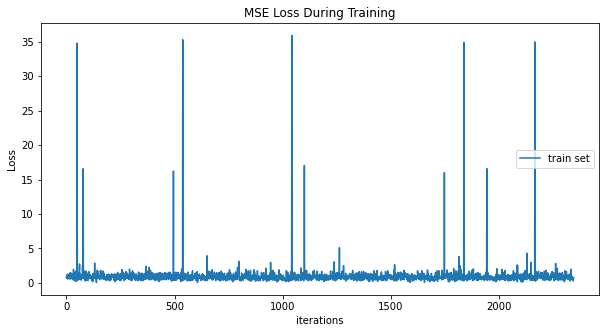

In [46]:
plt.figure(figsize=(10,5))
plt.title("MSE Loss During Training")
plt.plot(G_losses,label="train set")
# plt.plot(G_losses_val,label="val set")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

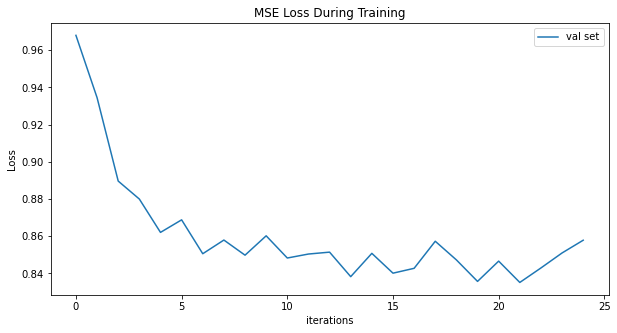

In [47]:
plt.figure(figsize=(10,5))
plt.title("MSE Loss During Training")
# plt.plot(G_losses,label="train set")
plt.plot(G_losses_val,label="val set")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train Predictions

In [48]:
train_ops = []
with torch.no_grad():
    for i, data in enumerate(train_set, 0):
        b_size = data[0].size(0)
        # Generate fake image batch with G
        fake = netG(data[0])
        
        train_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [49]:
train_reals = np.concatenate(list(x[0] for x in train_ops))
train_preds = np.concatenate(list(x[1] for x in train_ops))

In [50]:
df_results_train = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(train_reals,1),train_preds
    ))
    ,columns = ["true","pred"]
)

df_results_train.describe()

,true,pred
count,60000.000000,60000.000000
mean,0.004039,-0.018566
std,1.047344,0.367706
min,-0.221753,-0.677081
25%,-0.221753,-0.154715
50%,-0.221753,-0.090903
75%,-0.221753,-0.014003
max,66.412338,5.936547


In [51]:
df_results_train["pred_segment"] = pd.qcut(df_results_train["pred"],10)
df_results_train.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.678, -0.204]",-0.205789,-0.237397
"(-0.204, -0.169]",-0.182189,-0.185212
"(-0.169, -0.142]",-0.150260,-0.155073
"(-0.142, -0.116]",-0.122496,-0.129247
"(-0.116, -0.0909]",-0.091955,-0.103411
"(-0.0909, -0.0673]",-0.066274,-0.078984
"(-0.0673, -0.0379]",-0.055168,-0.053642
"(-0.0379, 0.02]",0.014243,-0.012365
"(0.02, 0.166]",0.087124,0.079413


In [52]:
mean_squared_error(df_results_train["true"], df_results_train["pred"]), df_results_train["true"].var()

(0.93171585, 1.0969297)

In [53]:
mean_absolute_error(df_results_train["true"], df_results_train["pred"]), (
    df_results_train["true"]-df_results_train["true"].mean()
).abs().mean()

(0.3457329, 0.42858404)

## Test Predictions

In [54]:
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        # Generate fake image batch with G
        gen_ip = data[0] 
        fake = netG(gen_ip)
        
        test_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [55]:
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))

In [56]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,-0.011023,-0.020310
std,0.963663,0.354433
min,-0.221753,-0.604073
25%,-0.221753,-0.154755
50%,-0.221753,-0.090333
75%,-0.221753,-0.012943
max,8.107509,5.602303


In [57]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-0.605, -0.203]",-0.171778,-0.236257
"(-0.203, -0.169]",-0.165531,-0.184937
"(-0.169, -0.142]",-0.121802,-0.155223
"(-0.142, -0.116]",-0.105143,-0.129087
"(-0.116, -0.0903]",-0.078073,-0.103055
"(-0.0903, -0.0663]",-0.080156,-0.078177
"(-0.0663, -0.0366]",-0.017686,-0.052678
"(-0.0366, 0.0206]",-0.001028,-0.011503
"(0.0206, 0.166]",0.057277,0.079993


In [58]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(0.8272788, 0.9286459)

In [59]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.34720564, 0.40129378)

# Gaussian Process Regression

In [61]:
model = GaussianProcessRegressor(
    kernel=kernels.RBF(length_scale=0.05)
    ,n_restarts_optimizer=0
).fit(x[val], y[val])

MemoryError: Unable to allocate 2.98 GiB for an array with shape (20000, 20000, 1) and data type float64

In [ ]:
y_pred_gauss = model.predict(x[test])
y_true_gauss = y[test]

In [ ]:
mean_absolute_error(y_true_gauss, y_pred_gauss), (
    np.abs(
        y_true_gauss-y_true_gauss.mean()
    )
).mean()

In [ ]:
mean_squared_error(y_true_gauss, y_pred_gauss), (
    np.abs(
        y_true_gauss-y_true_gauss.mean()
    )**2
).mean()